Based on:

https://huggingface.co/blog/ImranzamanML/fine-tuning-1b-llama-32-a-comprehensive-article


In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')


In [3]:
import torch
from trl import SFTTrainer
from transformers import TrainingArguments, TextStreamer
from unsloth.chat_templates import get_chat_template
from unsloth import FastLanguageModel
from datasets import Dataset
from unsloth import is_bfloat16_supported

from peft import LoraConfig, PeftModel
# Saving model
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, AutoModelForCausalLM, BitsAndBytesConfig

# Warnings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

/media/nmi/Data/dev/llama-3.2-fine-tuning/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [5]:
data = pd.read_csv("data/fpv_qa_formatted.csv")
data[:10]

,Question,Answer
0,"Вітаю, на ""GEPRC RAD VTX 5.8G 2.5W"" так само? ...","Мій перший 3d друк :slightly_smiling_face: , ..."
1,":worried_face:Де, саме в оголошеннях?. Куди за...",Тест відкритий до 11:00 ранку. Посилання можна...
2,https://www.youtube.com/watch?v=nENEdyQ5sQo&ab...,я так думаю що можна. але для цього треба інши...
3,А буде можливість пройти тест якщо на сьогодні...,"Так, за 2 тижні знову з'явиться нагода"
4,Підскажіть яким засобом провести гідроізоляцію...,Я на нижню сторону наніс клей B-7000 (який час...
5,"Добрий вечір, аналогічна ситуація, проворонив ...",Дякую буду чекати на повідомлення якщо воно бу...
6,"Добрий вечір. Підкажіть, будь ласка, чи скоро ...","Вітаємо! Пишіть сюди, будемо дивитись: folksfp..."
7,"Всім привіт, у мене є питання: якщо на двигуні...",напрямок оберту двигунів можна міняти в betafl...
8,Часто в комплект рам додається ще набір детале...,Ось у мене така ж рама і друкованих деталей не...
9,"підкажіть, будь-ласка, яка саме модифікація із...","Тут треба брати ELRS Left або M2, опція ELRS R..."


##  Exploratory data analysis

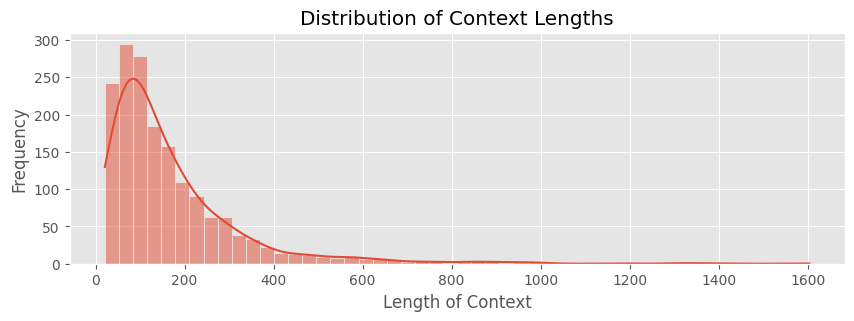

In [6]:
data['Context_length'] = data['Question'].apply(len)
plt.figure(figsize=(10, 3))
sns.histplot(data['Context_length'], bins=50, kde=True)
plt.title('Distribution of Context Lengths')
plt.xlabel('Length of Context')
plt.ylabel('Frequency')
plt.show()


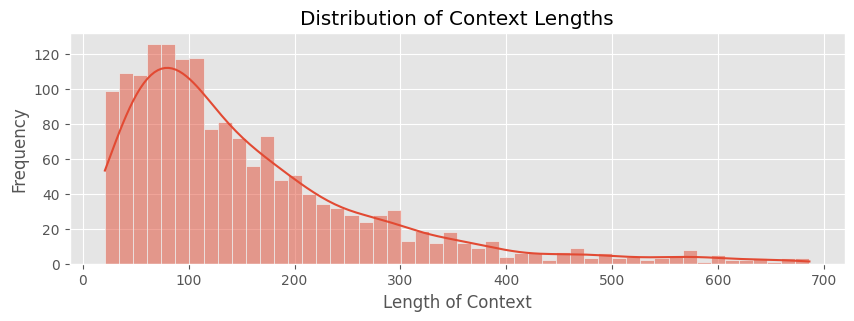

In [7]:
filtered_data = data[data['Context_length'] <= 700]

ln_Context = filtered_data['Question'].apply(len)
plt.figure(figsize=(10, 3))
sns.histplot(ln_Context, bins=50, kde=True)
plt.title('Distribution of Context Lengths')
plt.xlabel('Length of Context')
plt.ylabel('Frequency')
plt.show()


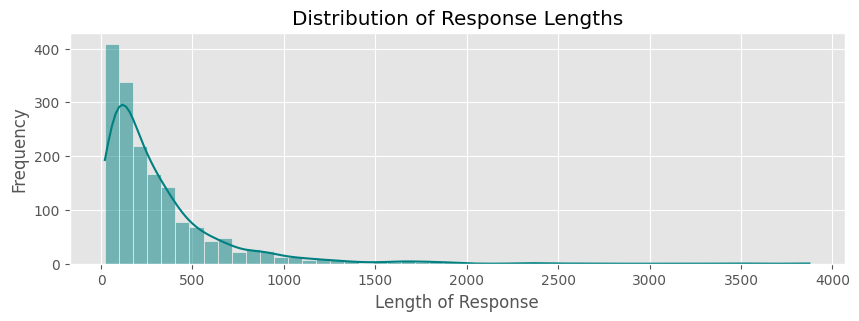

In [8]:
ln_Response = filtered_data['Answer'].apply(len)
plt.figure(figsize=(10, 3))
sns.histplot(ln_Response, bins=50, kde=True, color='teal')
plt.title('Distribution of Response Lengths')
plt.xlabel('Length of Response')
plt.ylabel('Frequency')
plt.show()


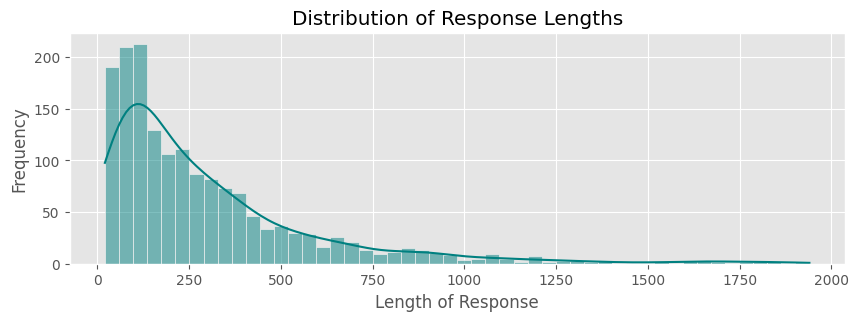

In [9]:
filtered_data = filtered_data[ln_Response <= 2000]

ln_Response = filtered_data['Answer'].apply(len)
plt.figure(figsize=(10, 3))
sns.histplot(ln_Response, bins=50, kde=True, color='teal')
plt.title('Distribution of Response Lengths')
plt.xlabel('Length of Response')
plt.ylabel('Frequency')
plt.show()


## Model training

###  Loading the model 

https://huggingface.co/tartuNLP/Llama-2-7b-Ukrainian

https://colab.research.google.com/drive/1PEQyJO1-f6j0S_XJ8DV50NkpzasXkrzd?usp=sharing#scrollTo=OJXpOgBFuSrc&uniqifier=1

In [1]:
model_name = 'tartuNLP/Llama-2-7b-Ukrainian'
q_model_name = 'NikolayKozloff/Llama-2-7b-Ukrainian-Q8_0-GGUF'
new_model = "llama-2-7b-ukrainian-ext"
output_dir = "./results"

In [ ]:
################################################################################
# QLoRA parameters
################################################################################

# LoRA attention dimension
lora_r = 64
# Alpha parameter for LoRA scaling
lora_alpha = 16
# Dropout probability for LoRA layers
lora_dropout = 0.1

################################################################################
# bitsandbytes parameters
################################################################################

# Activate 4-bit precision base model loading
use_4bit = True
# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"
# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"
# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

################################################################################
# TrainingArguments parameters
################################################################################

# Output directory where the model predictions and checkpoints will be stored
output_dir = "./results"
# Number of training epochs
num_train_epochs = 1
# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = False
# Batch size per GPU for training
per_device_train_batch_size = 4
# Batch size per GPU for evaluation
per_device_eval_batch_size = 4
# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1
# Enable gradient checkpointing
gradient_checkpointing = True
# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3
# Initial learning rate (AdamW optimizer)
learning_rate = 2e-4
# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001
# Optimizer to use
optim = "paged_adamw_32bit"
# Learning rate schedule
lr_scheduler_type = "cosine"
# Number of training steps (overrides num_train_epochs)
max_steps = -1
# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True
# Save checkpoint every X updates steps
save_steps = 0
# Log every X updates steps
logging_steps = 25

################################################################################
# SFT parameters
################################################################################

# Maximum sequence length to use
max_seq_length = None
# Pack multiple short examples in the same input sequence to increase efficiency
packing = False
# Load the entire model on the GPU 0
device_map = {"": 0}

In [12]:
# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

Your GPU supports bfloat16: accelerate training with bf16=True


In [ ]:
# Load base model
# model = AutoModelForCausalLM.from_pretrained(
#     model_name,
#     quantization_config=bnb_config,
#     device_map=device_map
# )
model = AutoModel.from_pretrained(
    q_model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1

# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training

# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

NameError: name 'bnb_config' is not defined

In [ ]:
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForCausalLM.from_pretrained(model_name)

Loading checkpoint shards: 100%|██████████| 3/3 [01:04<00:00, 21.44s/it]


### Prapare data for model feed 

Ти є експертом у галузі дронів та безпілотних систем. Твоє завдання — відповідати на технічні питання з чіткими, коректними та лаконічними поясненнями. Якщо запит виходить за межі твоєї спеціалізації, чесно повідомляй про це та заохочуй уточнення.


*** Ти — технічний консультант із дронів, який допомагає з питаннями про апаратне забезпечення, програмне забезпечення, експлуатацію та ремонт дронів. Відповідай зрозуміло, конкретно, з використанням технічних термінів, якщо це доречно. Якщо інформація недоступна, вкажи це і запропонуй можливі альтернативи. Якщо запит виходить за межі твоєї спеціалізації, чесно повідомляй про це та заохочуй уточнення.


Ти є віртуальним співрозмовником, який спеціалізується на наданні корисної інформації та відповідей, ґрунтуючись на історії групових чатів. Твоє завдання — відповідати точно, ввічливо, відповідно до контексту запиту. Якщо запит не відповідає доступним даним або є двозначним, вкажи на це і запропонуй уточнити запит.

Проаналізуй питання з точки зору технічного спеціаліста з дронів і надай точну та зрозумілу відповідь, використовуючи технічну термінологію там, де це доречно. Якщо відповідь потребує уточнень або залежить від контексту, поясни, які деталі потрібні для більш точної відповіді.

Розглянь запитання як задачу для спеціаліста з безпілотних технологій. Визнач, які аспекти дронів (апаратне забезпечення, програмне забезпечення, експлуатація тощо) стосуються цього питання, і надай зрозумілу відповідь з поясненнями або рекомендаціями.

Використовуючи знання про дрони, включаючи їх конструкцію, програмне забезпечення та експлуатацію, відповідай на запитання як задача з технічного аналізу. Якщо можливо, надавай рекомендації або посилання на релевантні матеріали.

Проаналізуй запитання як задачу, пов'язану з безпілотними системами, і надай оптимальне рішення чи відповідь. Пояснюй свою логіку, особливо якщо запитання стосується налаштування, ремонту або розробки дронів.

*** You are an FPV drone technical consultant who helps with questions about drone hardware, software, operation, and repair. Answer clearly, specifically, using technical terms when appropriate. If information is unavailable, indicate this and suggest possible alternatives. If the request is outside your area of ​​expertise, be honest and encourage clarification.

In [14]:
data_prompt = """You are an FPV drone technical consultant who helps with questions about drone hardware, software, operation, and repair. Answer clearly, specifically, using technical terms when appropriate. If information is unavailable, indicate this and suggest possible alternatives. If the request is outside your area of ​​expertise, be honest and encourage clarification.

### Input:
{}

### Response:
{}"""

EOS_TOKEN = tokenizer.eos_token
def formatting_prompt(examples):
    inputs       = examples["Question"]
    outputs      = examples["Answer"]
    texts = []
    for input_, output in zip(inputs, outputs):
        text = data_prompt.format(input_, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }


In [15]:
training_data = Dataset.from_pandas(filtered_data)
training_data = training_data.map(formatting_prompt, batched=True)


Map:   0%|          | 0/1655 [00:00<?, ? examples/s]

Map: 100%|██████████| 1655/1655 [00:00<00:00, 61808.91 examples/s]


In [16]:
training_data[1]

{'Question': ':worried_face:Де, саме в оголошеннях?. Куди заходити треба?:face_with_monocle:',
 'Answer': 'Тест відкритий до 11:00 ранку. Посилання можна знайти в оголошеннях На пошті має бути лист з посиланням або на каналі ffpv-оголошення Немає:loudly_crying_face: Знайшов, дякую! Вибачте, саме це повідомлення чомусь в спам улетіло!',
 'Context_length': 78,
 '__index_level_0__': 1,
 'text': 'You are an FPV drone technical consultant who helps with questions about drone hardware, software, operation, and repair. Answer clearly, specifically, using technical terms when appropriate. If information is unavailable, indicate this and suggest possible alternatives. If the request is outside your area of \u200b\u200bexpertise, be honest and encourage clarification.\n\n### Input:\n:worried_face:Де, саме в оголошеннях?. Куди заходити треба?:face_with_monocle:\n\n### Response:\nТест відкритий до 11:00 ранку. Посилання можна знайти в оголошеннях На пошті має бути лист з посиланням або на каналі f

In [17]:
# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="tensorboard"
)

# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=training_data,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
)


Map: 100%|██████████| 1655/1655 [00:00<00:00, 6779.46 examples/s]


In [18]:
# Train model
trainer.train()

# Save trained model
trainer.model.save_pretrained(new_model)

  0%|          | 0/414 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 172.00 MiB. GPU 0 has a total capacity of 11.75 GiB of which 117.50 MiB is free. Including non-PyTorch memory, this process has 11.01 GiB memory in use. Of the allocated memory 10.53 GiB is allocated by PyTorch, and 362.79 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

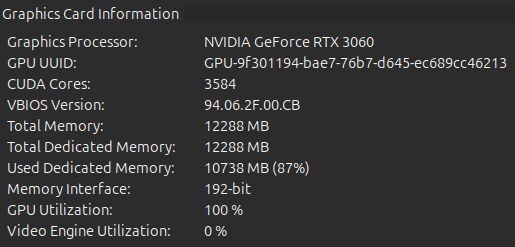


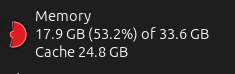


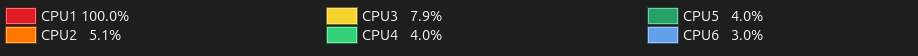

fpv_qa_formatted: 98min

help_qa: 365min

{'train_runtime': 21945.4287, 'train_samples_per_second': 0.461, 'train_steps_per_second': 0.004, 'train_loss': 2.118492379784584, 'epoch': 40.0}


fpv_qa_formatted: Привіт всім. Таке питання. Було не правильно підключено vtx max solo,  тепер не працює вентилятор, хоча відео ок. Це якось вирішується, чи тільки заміна передавача?

help_qa: Hello. Such a question. The vtx max solo was not connected correctly, now the fan does not work, although the video is ok. Is this somehow solved, or is it just a matter of replacing the transmitter?

In [15]:
text="Hello. Such a question. The vtx max solo was not connected correctly, now the fan does not work, although the video is ok. Is this somehow solved, or is it just a matter of replacing the transmitter?"


In [17]:
model = FastLanguageModel.for_inference(model)
inputs = tokenizer(
[
    data_prompt.format(
        #instructions
        text,
        #answer
        "",
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 1200, use_cache = True)
answer=tokenizer.batch_decode(outputs)
answer = answer[0].split("### Response:")[-1]
print("Answer of the question is:", answer)


Answer of the question is: 
I don't think so. I don't think the vtx is the issue. I think it's the receiver. I don't know if it's possible to fix it with a new receiver. I don't think it's possible to fix it with a new transmitter. I don't think it's possible to fix it with a new receiver. I don't think it's possible to fix it with a new transmitter. I don't think it's possible to fix it with a new receiver. I don't think it's possible to fix it with a new transmitter. I don't think it's possible to fix it with a new receiver. I don't think it's possible to fix it with a new receiver. I don't think it's possible to fix it with a new receiver. I don't think it's possible to fix it with a new receiver. I don't think it's possible to fix it with a new receiver. I don't think it's possible to fix it with a new receiver. I don't think it's possible to fix it with a new receiver. I don't think it's possible to fix it with a new receiver. I don't think it's possible to fix it with a new recei

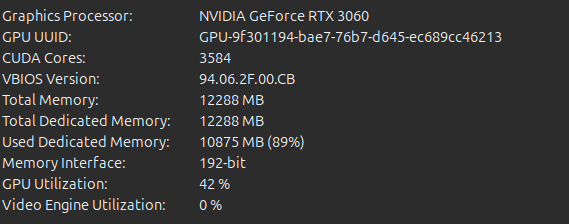


Answer of the question is: 


fpv_qa_formatted: 
Вітаю. Вітаю. Вітаю. Вітаю. Вітаю. .....


help_qa: 
I don't think so. I don't think the vtx is the issue. I think it's the receiver. I don't know if it's possible to fix it with a new receiver. I don't think it's possible to fix it with a new transmitter. I don't think it's possible to fix it with a new receiver. ...


In [18]:
model.save_pretrained("model/1B_finetuned_llama3.2_en")
tokenizer.save_pretrained("model/1B_finetuned_llama3.2_en")


('model/1B_finetuned_llama3.2_en/tokenizer_config.json',
 'model/1B_finetuned_llama3.2_en/special_tokens_map.json',
 'model/1B_finetuned_llama3.2_en/tokenizer.json')